<a href="https://colab.research.google.com/github/AleksandrSosnin/Transfer-Lerning/blob/main/HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning (семинары)

## Семинар 2. Representation learning

### Практическое задание

Заменить используемую сеть на менее "глубокую".  
Увеличить размер изображения, задав большее значение чем 256.  
Изменить соотношение стиля и контента.  
Сгенерировать стилизованное изображение, используя другие, выбранные вами изображения.

Специальные требования:
1. Ноутбук должен выполняться в Colab или в локальном Jupyter нотбуке. Изображения должны быть приложены (например, вклеены в текутовую ячейку), либо должны быть даны ссылки на них (URL).
2. Если ноутбук выложен в Colab, не забудьте разрешить к нему доступ. Преподаватель готов подождать получения доступа, но, к сожалению, без доступа, задание будет считаться несданным.

Скрипт можно выполнять в Jupyter на собственном ПК (в том числе на CPU), а можно в Google Colab.

**Замечание**: Иллюстрации первой части ноутбука могут не открываться в Google Colab. И пока мы не оптимизировали ноутбук для Colab, вы можете прочитать теорию в приложенном HTML файле.

In [27]:
!pip install torch torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

from torchvision import models, transforms
from torchvision.models import resnet18

import copy

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [29]:
import os
import requests


os.makedirs("images", exist_ok=True)


images = {
    "content1.jpg": "https://images.pexels.com/photos/4587997/pexels-photo-4587997.jpeg",
    "style1.jpg":   "https://images.pexels.com/photos/1025698/pexels-photo-1025698.jpeg",
    "content2.jpg": "https://images.pexels.com/photos/417173/pexels-photo-417173.jpeg",
    "style2.jpg":   "https://images.pexels.com/photos/279409/pexels-photo-279409.jpeg"
}

headers = {"User-Agent": "Mozilla/5.0"}
for fname, url in images.items():
    path = os.path.join("images", fname)
    print(f"Downloading {fname}...", end=" ")
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        with open(path, "wb") as f:
            for chunk in r.iter_content(1024):
                f.write(chunk)
        print("OK")
    else:
        print(f"Failed ({r.status_code})")

print("\nFiles in images/:", os.listdir("images"))




Files in images/: ['content1.jpg', 'style1.jpg', 'style2.jpg', 'content2.jpg']


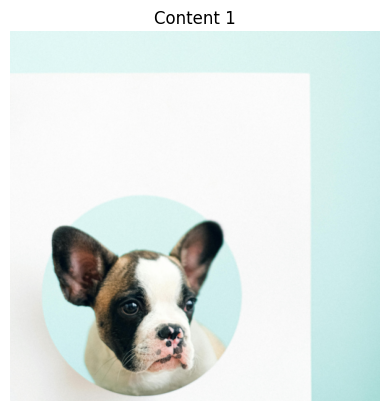

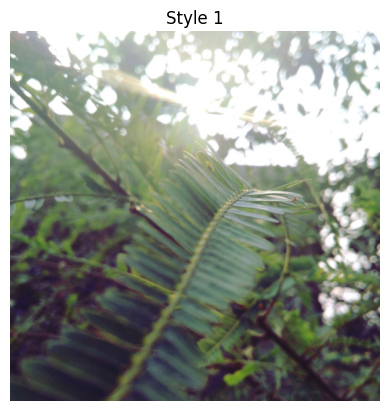

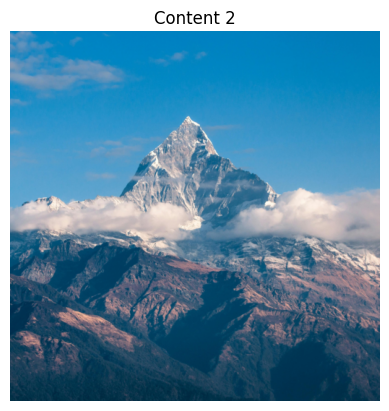

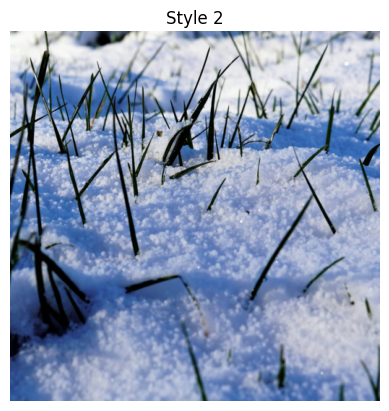

In [39]:
Image.MAX_IMAGE_PIXELS = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()
])

def image_loader_from_path(path):
    img = Image.open(path).convert("RGB")
    return loader(img).unsqueeze(0).to(device)

content1 = image_loader_from_path("images/content1.jpg")
style1   = image_loader_from_path("images/style1.jpg")
content2 = image_loader_from_path("images/content2.jpg")
style2   = image_loader_from_path("images/style2.jpg")

def imshow(tensor, title=""):
    unloader = transforms.ToPILImage()
    img = tensor.cpu().clone().squeeze(0)
    plt.imshow(unloader(img))
    plt.title(title)
    plt.axis("off")
    plt.show()

imshow(content1, "Content 1")
imshow(style1,   "Style 1")
imshow(content2, "Content 2")
imshow(style2,   "Style 2")




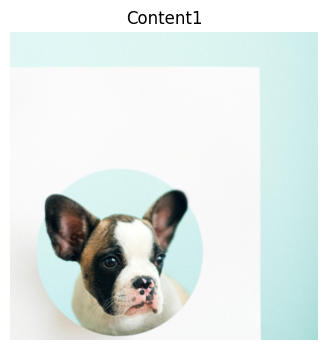

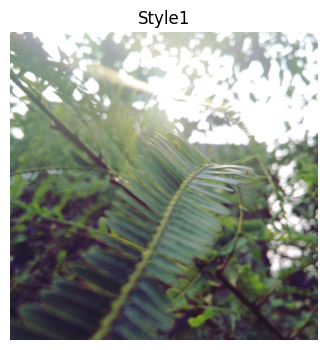

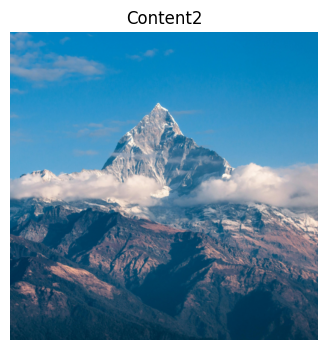

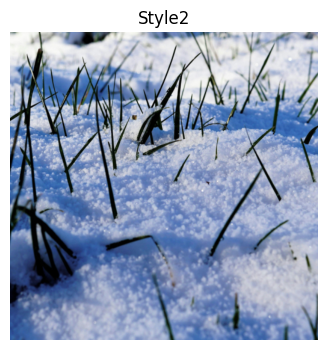

In [40]:
def imshow(tensor, title=""):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone().squeeze(0)
    image = unloader(image)
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

imshow(content1, "Content1")
imshow(style1,   "Style1")
imshow(content2, "Content2")
imshow(style2,   "Style2")

In [41]:
resnet = models.resnet18(pretrained=True).to(device).eval()

In [42]:
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        layers = list(backbone.children())[:5]
        self.slice = nn.Sequential(*layers)
    def forward(self, x):
        return self.slice(x)

feature_extractor = FeatureExtractor(resnet).to(device).eval()

print("Feature Extractor готов!")

Feature Extractor готов!


In [43]:
def gram_matrix(x):
    b, c, h, w = x.size()
    features = x.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

print("Грам-матрица готова!")


Грам-матрица готова!


In [46]:
def run_style_transfer(c_img, s_img, num_steps=200, style_weight=1e6, content_weight=1):
    input_img = c_img.clone().requires_grad_(True)
    optimizer = optim.LBFGS([input_img])

    c_feat = feature_extractor(c_img)
    s_feat = feature_extractor(s_img)
    s_gram = gram_matrix(s_feat)

    run = [0]
    while run[0] <= num_steps:
        def closure():
            optimizer.zero_grad()
            i_feat = feature_extractor(input_img)
            c_loss = F.mse_loss(i_feat, c_feat)
            s_loss = F.mse_loss(gram_matrix(i_feat), s_gram)
            loss   = content_weight * c_loss + style_weight * s_loss
            loss.backward(retain_graph=True)
            run[0] += 1
            return loss
        optimizer.step(closure)

    return input_img.detach()


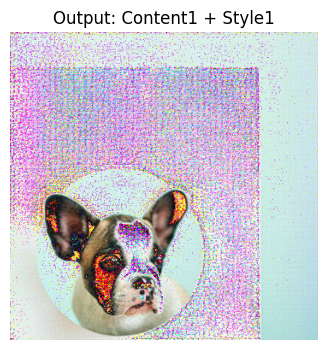

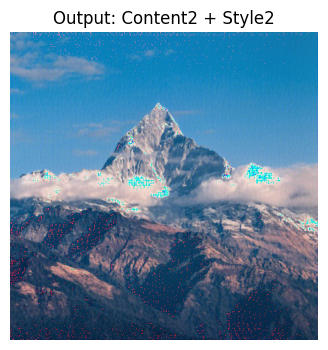

In [47]:
output1 = run_style_transfer(content1, style1,
                             num_steps=200,
                             style_weight=1e6,
                             content_weight=1e2)
imshow(output1, "Output: Content1 + Style1")

output2 = run_style_transfer(content2, style2,
                             num_steps=200,
                             style_weight=5e5,
                             content_weight=1e2)
imshow(output2, "Output: Content2 + Style2")
